In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Build model

In [3]:
#auto encoder
def auto_encoder(x):
    encoder = tf.layers.dense(x, en_dim, activation=tf.nn.sigmoid)
    out = tf.layers.dense(encoder, out_dim)
    return out

In [4]:
def model_fn(features, labels, mode):
    
    x = features['images']
    y = auto_encoder(x)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=y)
    
    loss_fn = tf.reduce_mean(tf.pow(x - y, 2))
    train_op = tf.train.RMSPropOptimizer(0.01).minimize(loss_fn, global_step=tf.train.get_global_step()) 
    accuracy_ = tf.metrics.accuracy(labels=x, predictions=y)
    
    est_spec = tf.estimator.EstimatorSpec(mode=mode, predictions=y, loss=loss_fn, 
                                          train_op=train_op, eval_metric_ops={'accuracy':accuracy_})
    
    return est_spec

In [5]:
def classification_nn(x):
    layer1 = tf.layers.dense(x, hid_dim, activation=tf.nn.relu)
    out = tf.layers.dense(layer1, nn_out_dim)
    return out

In [6]:
def model_fn_nn(features, labels, mode):
    x = features['images']
    output = classification_nn(x)
    y = tf.argmax(output, axis=1)
    pred_prob = tf.nn.softmax(output)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=y)
    
    loss_fn = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=tf.cast(labels, dtype=tf.int32)))
    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss_fn, global_step=tf.train.get_global_step())   
    accuracy_ = tf.metrics.accuracy(labels=labels, predictions=y)
    
    est_spec = tf.estimator.EstimatorSpec(mode=mode, predictions=y, loss=loss_fn, 
                                          train_op=train_op, eval_metric_ops={'accuracy':accuracy_})
    
    return est_spec

In [7]:
def _input_model(_x, _y, _xt, _yt, en, od, hd, nod, steps=1000):
    global en_dim
    global out_dim
    global hid_dim
    global nn_out_dim
    en_dim = en
    out_dim = od
    hid_dim = hd
    nn_out_dim = nod
    
    input_fn = tf.estimator.inputs.numpy_input_fn(x = {'images':_x},
                                             y = _x, batch_size=2048,
                                                  num_epochs=1000,
                                                  shuffle=False)
    global model
    model = tf.estimator.Estimator(model_fn)
    
    print('\nTrain -->')
    model.train(input_fn, steps=steps)
    
    print('\nEval -->')
    eval_fn = tf.estimator.inputs.numpy_input_fn(x = {'images':_x},
                                             y = _x, batch_size=2048,
                                                  shuffle=False)
    print(model.evaluate(eval_fn))
    
    print('\nConvert -->')
    test_fn = tf.estimator.inputs.numpy_input_fn(x = {'images': _xt},
                                                 batch_size=2048,
                                                  shuffle=False)
    results = model.predict(test_fn)
    
    dtype='float64'
    _res = np.empty(_xt.shape, dtype=dtype)
   

    for i, res in enumerate(results):
        _res[i] = np.asarray(res, dtype=dtype)
    
    #plt.imshow(np.asarray(_res[0], dtype=dtype).reshape(28, 28), cmap='gray')
    plt.imshow(np.asarray(_res[0,:56]).reshape(8, 7), cmap='gray')
    
    print('\n----------\nclassification')
    global model_nn
    
    input_fn_classification = tf.estimator.inputs.numpy_input_fn(x = {'images': _x},
                                             y = _y, batch_size=2048,
                                                  num_epochs=1000,
                                                  shuffle=False)
    
    print(_res.shape, _yt.shape)
    eval_fn_classification = tf.estimator.inputs.numpy_input_fn(x = {'images': _res},
                                             y = _yt, batch_size=2048,
                                                  shuffle=False)
    
    model_nn = tf.estimator.Estimator(model_fn_nn)
    print('\nTrain -->')
    model_nn.train(input_fn_classification, steps=steps)
    print('\n')
    print('\nEval -->')
    print(model_nn.evaluate(eval_fn_classification))
    
    return _res

# MNIST

In [7]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../data/mnist/", one_hot=False)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [ ]:
_input_model(mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels, 5, 28*28, 256, 10)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgl3u1d1e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff96bacc7b8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpgl3u1d1e/model.ckpt.
INFO:tensorflow:loss = 0.122029014, step = 1
INFO:tensorflow:global_step/sec: 4.96421
INFO:tensorflow:loss = 0.09420564, step = 101 (20.151 sec)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk95mevwc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4a10ad4e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpk95mevwc/model.ckpt.
INFO:tensorflow:loss = 0.12486681, step = 0


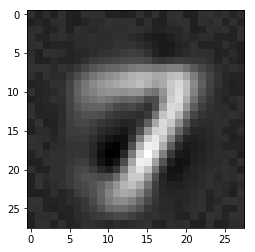

In [10]:
_input_model(mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels, 10, 28*28, 256, 10)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpemcibatv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4a114dce48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpemcibatv/model.ckpt.
INFO:tensorflow:loss = 0.13215744, step = 0


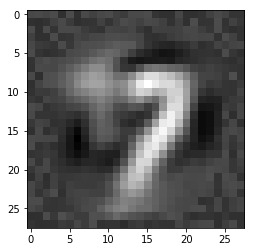

In [11]:
_input_model(mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels, 20, 28*28, 256, 10)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvnawviuo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4a1a3647b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpvnawviuo/model.ckpt.
INFO:tensorflow:loss = 0.18380947, step = 0


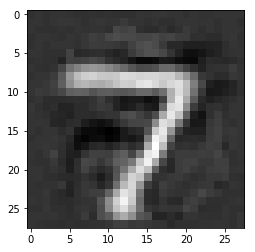

In [12]:
_input_model(mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels, 100, 28*28, 256, 10)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpx5c75ymb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4a10cfa748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpx5c75ymb/model.ckpt.
INFO:tensorflow:loss = 0.22203764, step = 0


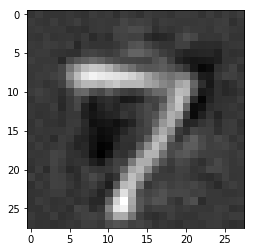

In [13]:
_input_model(mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels, 200, 28*28, 256, 10)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsk5dx67u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4a10fe06a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpsk5dx67u/model.ckpt.
INFO:tensorflow:loss = 0.30051628, step = 0


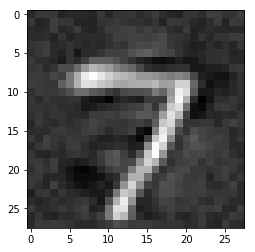

In [14]:
_input_model(mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels, 500, 28*28, 256, 10)

# SPAMBASE

In [9]:
spam_data = np.loadtxt('../../data/spambase/spambase.data', delimiter=',')

In [10]:
y_all = spam_data[:, -1]
spam_data = spam_data[:, :-1]

In [11]:
# train - 3.5k test - 1.1k
X, y = spam_data[:3500], y_all[:3500]
_X, _y = spam_data[3500:], y_all[3500:]

In [53]:
_input_model(X, y, _X, _y, 5, 57, 32, 2, 3000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk667jfcl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efce867fcc0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpk667jfcl/model.ckpt.
INFO:tensorflow:loss = 16327.952022647272, step = 1
INFO:tensorflow:global_step/sec: 89.1868
INFO:tensorflow:loss = 4107.941626624056, step = 101 (1.124 sec)
INFO:tensorflow:global_step/sec: 90.0868
INFO:tensorflow:loss = 15754.282088237198, step = 201 (1.107 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp35n3ihbg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f90380fd6d8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp35n3ihbg/model.ckpt.
INFO:tensorflow:loss = 16320.381510034387, step = 1
INFO:tensorflow:global_step/sec: 59.1931
INFO:tensorflow:loss = 4016.016008736045, step = 101 (1.691 sec)
INFO:tensorflow:global_step/sec: 66.4413
INFO:tensorflow:loss = 15320.867038135795, step = 201 (1.505 sec)
INFO:tensorflow:global_ste

array([[-4.25284222e-03,  2.94791007e-01,  8.26229239e-02, ...,
         1.80979138e+00,  6.84554649e+00,  2.86761757e+01],
       [ 1.59783440e-01,  1.58693446e+00,  3.49775033e-01, ...,
         1.66999440e+00,  1.59937525e+01,  5.07714019e+01],
       [ 1.25969347e-01,  3.44113681e-02,  2.40893496e-01, ...,
         2.05449505e+00,  1.13468675e+01,  5.40037775e+01],
       ...,
       [ 1.39908060e-01,  4.38115745e-01,  3.19419552e-01, ...,
         2.44328178e+00,  3.36091641e+01,  1.25428882e+02],
       [ 1.79063562e-01,  1.36999730e-01,  2.48510916e-01, ...,
         2.43880136e+00,  2.18578741e+01,  8.84183931e+01],
       [ 1.22292249e-01, -2.87007884e-01,  2.85660132e-01, ...,
         2.02938514e+00,  8.22845962e+00,  4.10680679e+01]])

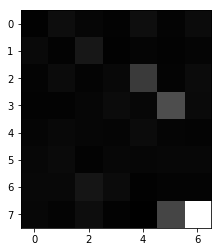

In [12]:
_input_model(X, y, _X, _y, 20, 57, 32, 2, 3000)

In [43]:
_input_model(X, y, _X, _y, 50, 57, 32, 2, 3000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_mi57r3x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efce88acb00>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_mi57r3x/model.ckpt.
INFO:tensorflow:loss = 16317.937142385665, step = 1
INFO:tensorflow:global_step/sec: 66.4881
INFO:tensorflow:loss = 3877.191186166485, step = 101 (1.505 sec)
INFO:tensorflow:global_step/sec: 64.5091
INFO:tensorflow:loss = 14680.118008755491, step = 201 (1.551 sec)
INFO:tensorflow:global_ste

array([[ 5.25460252e-02,  3.15838490e-01,  2.27705020e-01, ...,
         2.31299749e+00,  6.33298093e+00,  3.00924325e+01],
       [ 2.37072681e-02,  3.88974331e-01,  3.24920116e-02, ...,
         3.89932707e+00,  1.73593817e+01,  6.42625453e+01],
       [ 8.06401312e-02,  1.49845986e-01,  2.82415500e-01, ...,
         2.94460326e+00,  8.57271893e+00,  5.09467667e+01],
       ...,
       [ 1.03372350e-02, -8.47622683e-02,  5.11133601e-02, ...,
         5.21010815e+00,  1.65867413e+01,  1.02217562e+02],
       [ 4.00430580e-02, -3.48195186e-02,  1.84198731e-01, ...,
         2.73153900e+00,  1.06685204e+01,  7.29498380e+01],
       [ 8.41494295e-02,  1.28381549e-01,  2.26144432e-01, ...,
         2.21592562e+00,  6.92543301e+00,  3.45805374e+01]])

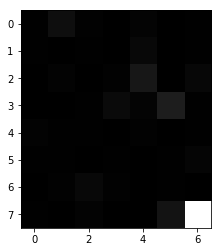

In [69]:
plt.imshow(np.asarray(result[0,:56]).reshape(8, 7), cmap='gray')

In [66]:
_X[:,:50].shape

(1101, 50)

# Fashion

In [76]:
df = pd.read_csv('../../data/fashionmnist/fashion-mnist_train.csv')

In [77]:
labels = np.array(df['label'], dtype='float64')
del df['label']
data = np.array(df, dtype='float64')
del df

In [78]:
X, y = data[:50000], labels[:50000]
_X, _y = data[50000:], labels[50000:]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2lm52h6o', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efce8246160>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp2lm52h6o/model.ckpt.
INFO:tensorflow:loss = 13171.255980266222, step = 1
INFO:tensorflow:global_step/sec: 1.82529
INFO:tensorflow:loss = 4877.912559401869, step = 101 (54.788 sec)
INFO:tensorflow:global_step/sec: 1.92212
INFO:tensorflow:loss = 4176.905428892984, step = 201 (52.022 sec)
INFO:tensorflow:global_st

array([[ 1.80629545, -1.79103672, -1.71414101, ..., -6.58413887,
         1.12160573,  1.89598649],
       [ 1.70631549, -1.69870086, -1.59533802, ..., -1.32145228,
         2.56241435,  2.05888107],
       [ 1.69145292, -1.68300197, -1.42521731, ...,  0.62933393,
         2.59225206,  2.02072257],
       ...,
       [ 1.74444448, -1.75477049, -1.60247298, ..., -1.22782841,
         2.93598404,  2.10815936],
       [ 1.74170216, -1.74259599, -1.64328308, ..., 12.63357697,
         7.76785555,  2.54135922],
       [ 1.74653849, -1.76541984, -1.64800858, ...,  3.58377578,
         3.55512581,  2.0774638 ]])

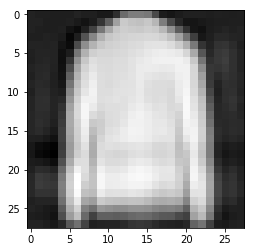

In [79]:
_input_model(X, y, _X, _y, 500, 28*28, 256, 10, 2000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmph8h6gk9l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efce8944128>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmph8h6gk9l/model.ckpt.
INFO:tensorflow:loss = 13179.394291446482, step = 1
INFO:tensorflow:global_step/sec: 4.04093
INFO:tensorflow:loss = 5337.998159160041, step = 101 (24.750 sec)
INFO:tensorflow:global_step/sec: 3.80496
INFO:tensorflow:loss = 4667.2705178534525, step = 201 (26.282 sec)
INFO:tensorflow:global_s

array([[ 0.8140458 ,  0.80846818, -0.70355939, ..., -8.45609808,
        -1.74580815,  0.74499441],
       [ 0.70037658,  0.6979303 , -0.6345538 , ...,  1.02384956,
         1.27490119,  0.84811631],
       [ 0.76545917,  0.79058265, -0.58523822, ..., -7.81673132,
        -2.69915728,  0.69412846],
       ...,
       [ 0.74960336,  0.7407963 , -0.59020588, ...,  0.17553629,
         0.80736769,  1.01126332],
       [ 0.72099633,  0.73542777, -0.63902395, ...,  9.54570069,
         3.9576431 ,  1.26229188],
       [ 0.64021356,  0.64811996, -0.56382832, ...,  2.58969947,
         0.8471237 ,  0.84637912]])

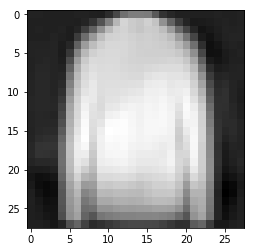

In [80]:
_input_model(X, y, _X, _y, 200, 28*28, 256, 10, 2000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_90s78td', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efce1c7ff98>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Train -->
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_90s78td/model.ckpt.
INFO:tensorflow:loss = 13180.968117157268, step = 1
INFO:tensorflow:global_step/sec: 5.63828
INFO:tensorflow:loss = 6706.352403760429, step = 101 (17.737 sec)
INFO:tensorflow:global_step/sec: 6.07193
INFO:tensorflow:loss = 5108.360466207583, step = 201 (16.471 sec)
INFO:tensorflow:global_st

array([[ 0.40083333, -0.38923581, -0.3515717 , ..., -2.05357168,
        -1.24010103,  0.30540645],
       [ 0.30616467, -0.30304123, -0.28697683, ..., -2.32789428,
        -0.79106072,  0.29327512],
       [ 0.33069076, -0.29777174, -0.13908515, ...,  0.92059981,
        -0.39448587,  0.49372569],
       ...,
       [ 0.36402661, -0.33572243, -0.21584481, ...,  4.63742776,
         3.22308828,  0.82286202],
       [ 0.34550225, -0.31319486, -0.1850794 , ..., 12.16024568,
         5.148063  ,  1.01881308],
       [ 0.30173256, -0.28484623, -0.18848706, ...,  0.31644539,
         0.04248465,  0.41774035]])

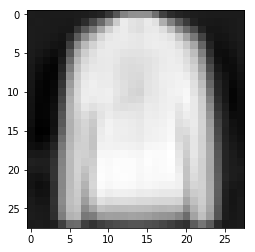

In [81]:
_input_model(X, y, _X, _y, 100, 28*28, 256, 10, 2000)